# SRT Log Analyzer

![SRT Logo](https://camo.githubusercontent.com/9755ff8b363a9bdaf422e6cc7760be1c2399a401/687474703a2f2f7777772e737274616c6c69616e63652e6f72672f77702d636f6e74656e742f75706c6f6164732f5352545f746578745f686f725f6c6f676f5f677265792e706e67 "SRT Logo")

## Abstract 

The Secure Reliable Transport (SRT) is an excellent tool for transporting video/audio streams over the public Internet but its logs can be sometimes overwhelming and the analysis can take considerable amount of time if done manually. 

I have tried to create a tool to do that automatically converting the output CSV file into a dataframe and then applying different analysis on it. The script should be agnostic whether the log files are coming from an SRT transmitter or SRT receiver.

## Introduction

Sending video over UDP across the Internet is a problem due to the nature of UDP. Depending on network conditions packet loss is likely. Sending high quality video is very likely to result in a bad user experience.

### What is SRT

SRT stands for Secure Reliable Transport and is an open source transport technology that optimizes streaming performance over the public Internet.

* Secure - Encrypts Video Streams
* Reliable - Recovers from Packet Loss
* Transport - Dynamically Adapts to Changing Network Conditions

As audio/video packets are streamed from a source to a destination device, SRT detects and adapts to the real-time network conditions between the two endpoints. 

SRT helps compensate for jitter and bandwidth fluctuations due to congestion over noisy networks, such as the public Internet. Its error recovery mechanism minimizes the packet loss typical of Internet connections. And SRT supports AES encryption for end-to-end security, keeping the transported streams safe from prying eyes.

It is an open source library provided by [Haivision](https://www.haivision.com/) and published the source code in [Github](https://github.com/Haivision/srt) under the Mozilla Public License 2.0 (MPLv2.0).

### SRT Modes of Operation

SRT can be run in either Caller, Listener or Rendezvous mode. 

The mode only tells who initiated the connection, not in what direction the UDP stream is sent. In Rendezvous mode both nodes are initiating the communication. Rendezvous mode is used when both nodes are behind firewalls and allows for communicating without configuring the firewall.

### SRT Error Recovery Mechanism

Basically both the transmitting and receiving part are using an UDP port greater than 1024 to establish a connection between each other and apart of sending the stream, they are also establishing a service channel, which is continuously monitoring the line status and if needed is resending or re-orders the packets. 

The technique used by SRT to recover packet loss is called ARQ (Automatic Repeat Request). ARQ basically works by having a sender/caller setting a sequence number on each packet and a receiver/listener that checks that all packets have been received in correct order. Any lost packets are detected and the listener can request a retransmission of those packets.

The caller is storing sent packets in a cache in case it need to resend them and the listener buffers received packets to be able to reorder the received packets in case they arrive in wrong order.

### Building SRT

The SRT library can be easily compiled under Linux with the following commands:
```bash
git clone https://github.com/Haivision/srt.git
./configure
make
sudo make install
```
In addition to building the SRT library this also builds a couple of tools, one of which is `srt-live-transmit` for trying out the SRT transport.

### Basic Usage of the srt-live-transmit Tool
The tool `srt-live-transmit` is used to transport data between different points. It supports SRT/UDP input and output. In case of SRT Caller -> SRT Listener mode we can start the streaming with the following command:
```
srt-live-transmit udp://127.0.0.1:1234 srt://62.87.84.207:10000
```
where the `udp://127.0.0.1:1234` is the input unicast stream, but this can be another SRT stream, or just a multicast and `srt://62.87.84.207:10000` is the public IP address of the listener and 10000 is the assigned port. 

It is important to note, that in Caller -> Listener mode, the Listener should have a public IP address and the port should be higher or equal to 1024. 

On the listener side we need to define only the listening port and the output of the stream. Usually the output is also an UDP streaming: 
```
srt-live-transmit srt://:10000 udp://225.0.0.0:20000
```

It is important to note the the above commands don't include any reporting of the stats. If you want to enable them you can change the above line to:
```
srt-live-transm “srt://:10000?latency=400” “udp://225.0.0.0:1234” -r:1000 -pf:csv -statsout:/path/to/log_directory/srt_stats.csv 
```
Here every 1000ms a new entry in the `/path/to/log_directory/srt_stats.csv` will be added, if you want to change the frequency of reporting, you can change the `-r:1000` value. 

### SRT Log Parameters
A full list and description of the SRT log parameters can be found [here](https://github.com/Haivision/srt/blob/master/docs/statistics.md).

# Live Demo

I have used [Streamlit](https://www.streamlit.io/) to create a web portal from where you can upload your own CSV files, and do all hereto shown analysis in an interactive form and even to export the data in an Excel format. 

I have even prepared a `Dockerfile` and `requirements.txt` to build a docker container and wanted to deploy it on my test Raspberry Pi, but unfortunately the latest versions of pandas and pyarrow have problems compiling inside a docker container, so I would need to show it in a non-containerized version. Demo Video of the web portal can be found [here](https://cloud.gstoyanov.com/s/xm8QoENAe8iapeM). 

The source code is available publicly at my personal [Github account](https://github.com/stoyanovgeorge/srt_log_analyzer)

**The demo is available at [https://gstoyanov.com/](https://gstoyanov.com/).**



# SRT Log Analyzer Code 

### Import Statements

In [1]:
%matplotlib inline

import datetime
import pandas as pd
import matplotlib.pyplot as plt

### Dataframe Formatting

The CSV log files usually contains information for both sides (receiver and sender) so we can remove the receiver specific columns from the sender log files and the sender specific columns from the receiver log files. This can be done with the `df_format` function which takes as parameters the original dataframe and a boolean which is `True` if the logs are for SRT sender and `False` if they are for a SRT receiver. The output of the function is the cleaned dataframe and the number of rows and columns. 

In [2]:
def df_format(dataframe, sender):
    """Formats the Dataframe and removes the redundant columns whether the log files are for 
    receiver or sender device  

    Args:
        dataframe ([dataframe]): Input dataframe
        sender ([bool]): Returns True if the logs are for a SRT sender and False for SRT receiver
    Returns:
        cleaned_df ([dataframe]): Output and cleaned dataframe
        num_rows ([integer]): Number of Rows of the new Cleaned Dataframe
        num_cols ([integers]): Number of Columns in the new cleaned Dataframe
    """
    
    if sender:
        # Dropping all Receiver Columns
        cleaned_df = dataframe.drop(["pktRecv", "pktRcvLoss", "pktRcvDrop", "pktRcvRetrans", "pktRcvBelated", 
                                     "byteRecv", "byteRcvLoss", "byteRcvDrop", "mbpsRecvRate", "mbpsMaxBW", 
                                     "pktRcvFilterExtra", "pktRcvFilterSupply", "pktRcvFilterLoss"], axis = 1)
    else:
        # Dropping all Sender Columns
        cleaned_df = dataframe.drop(["pktSent", "pktSndLoss", "pktSndDrop", "pktRetrans", "byteSent", 
                                     "byteSndDrop", "mbpsSendRate", "mbpsMaxBW", "pktSndFilterExtra"], axis = 1)
    # Originally the Time column contains the elapsed time in milliseconds
    # Converting the milliseconds to human timestamp
    cleaned_df["Seconds"] = pd.to_datetime(cleaned_df.Time).astype(int) / 10 ** 3
    
    # Converting the Time column into datetime and then converting it to timestamp
    cleaned_df.Time = pd.to_datetime(cleaned_df.Time, unit = "ms").dt.time
    
    # Reordering the Dataframe and placing the Seconds column at the beginning instead of the end
    df_cols = list(cleaned_df.columns.values)
    df_cols.pop(df_cols.index("Seconds"))
    cleaned_df = cleaned_df[["Seconds"] + df_cols]
    
    # Finding out the number of rows and columns     
    num_rows = cleaned_df.shape[0]
    num_cols = cleaned_df.shape[1]
    
    return cleaned_df, num_rows, num_cols

### RTT (Round Trip Time) Calculation

The round trip time is the time in milliseconds it takes for a data packet to be sent to a destination plus the time it takes for an acknowledgment of that packet to be received back at the origin. 

If the link is stable and there is no network congestion the RTT should stay relatively stable throughout the data transmission. Higher than normal RTT might cause packet re-ordering or even packet loss. That is why the SRT protocol is numbering each packet and adding an additional buffer latency in the system, in order to be able to recover from errors caused by high RTT. 

The default latency used is 150ms and it should be at least three times higher than the average RTT between the sender and receiver. A higher latency is adding additional latency in the system, so it is always advisable to use as low latency as possible. 

The default latency can be re-written by passing `srt://62.87.84.207:10000?latency=400` this will increase the latency on both sides to 400ms. 

In [3]:
def stats_calc(dataframe):
    """Calculates the minimum, maximum and average Round Trip Time(RTT)

    Args:
        dataframe ([dataframe]): Input Dataframe

    Returns:
        min_rtt ([float]): Minimum Round Trip Time in ms
        max_rtt ([float]): Maximum Round Trip Time in ms
        avg_rtt ([float]): Average Round Trip Time in ms
        latency ([integer]): Latency in ms
        duration ([integer]): Duration of the transmission
    """
    min_rtt = round(dataframe.msRTT.min(), 3)
    max_rtt = round(dataframe.msRTT.max(), 3)
    avg_rtt = round(dataframe.msRTT.mean(), 3)
    latency = dataframe.RCVLATENCYms.iloc[-1]
    duration = dataframe.Time.iloc[-1]
    return min_rtt, max_rtt, avg_rtt, latency, duration

### Getting the Stats of the Line

The most important metrics of the line are its bandwidth, the dropped, lost and re-transmitted packets.

In a perfect world we should not have any lost data packets, because this would cause freezing of the picture or pixelization. 

In [4]:
def line_stats(dataframe, sender, num_rows):
    """Returns Dataframes containing the N number of n-smallest values 
    for the bandwidth, lost, dropped and retransmitted data packets 

    Args:
        dataframe ([dataframe]): Input cleaned Dataframe
        sender ([bool]): True for SRT Sender and False for SRT Receiver
        num_rows ([integer]): Defines the number of rows

    Returns:
        dataframes: Dataframes containing the N number of n-smallest values 
    for the bandwidth, lost, dropped and retransmitted data packets if present.
    """
    if sender:
        # Printing the lowest bandwidth entry
        print("Line Bandwidth Stats:")
        print(f"Minimal Line Bandwidth: {dataframe.mbpsBandwidth.min()} Mbps")

        snd_cols = ["Time", "msRTT", "mbpsBandwidth", "pktSndDrop", "pktSndLoss", "pktRetrans", "mbpsSendRate"]
        mbpsSendRate_df = dataframe.nsmallest(num_rows, "mbpsBandwidth")[snd_cols]
        
        # Checking if there are pktSndLoss Data Packets
        if dataframe.pktSndLoss.max() > 0:
            print("Lost Data Packets Stats:")
            print(f"Maximal Lost Sent Data Packets: {dataframe.pktSndLoss.max()} packets")
            print(f"Total Lost Sent Data Packets: {dataframe.pktSndLoss.sum()} packets")
            pktSndLoss_df = dataframe.nlargest(num_rows, "pktSndLoss")[snd_cols]
        else:
            print("No Lost Sent Data Packets Detected")
            pktSndLoss_df = None

        # Checking if we have dropped sent data packets 
        if dataframe.pktSndDrop.max() > 0:
            print("Dropped Data Packets Stats:")
            print(f"Maximal Dropped Sent Data Packets: {dataframe.pktSndDrop.max()} packets")
            print(f"Total Dropped Sent Data Packets: {dataframe.pktSndDrop.sum()} packets")
            pktSndDrop_df = dataframe.nlargest(num_rows, "pktSndDrop")[snd_cols]
        else:
            print("No Dropped Sent Data Packets Detected")
            pktSndDrop_df = None

        # Checking if we have retransmitted sent data packets 
        if dataframe.pktRetrans.max() > 0:
            print("Retransmitted Data Packets Stats:")
            print(f"Maximal Retransmitted Data Packets: {dataframe.pktRetrans.max()} packets")
            print(f"Total Retransmitted Data Packets: {dataframe.pktRetrans.sum()} packets")
            pktRetrans_df = dataframe.nlargest(num_rows, "pktRetrans")[snd_cols]
        else:
            print("No Retransmitted Data Packets Detected")
            pktRetrans_df = None
        # Returning all the dataframes
        return mbpsSendRate_df, pktSndLoss_df, pktSndDrop_df, pktRetrans_df
    
    else:
        # The logs are for Receiving Device
        print("Line Bandwidth Stats:")
        print(f"Minimal Line Bandwidth: {dataframe.mbpsBandwidth.min()} Mbps")
        rcv_cols = ["Time", "msRTT", "mbpsBandwidth", "pktRcvDrop", "pktRcvLoss", "pktRcvRetrans", "mbpsRecvRate"]
        mbpsBandwidth_df = dataframe.nsmallest(num_rows, "mbpsBandwidth")[rcv_cols]
        if dataframe.pktRcvLoss.max() > 0:
            print("Lost Received Data Packets Stats:")
            print(f"Maximal Lost Received Data Packets: {dataframe.pktRcvLoss.max()} packets")
            print(f"Total Lost Received Data Packets: {dataframe.pktRcvLoss.sum()} packets")
            pktcvLoss_df = dataframe.nlargest(num_rows, "pktRcvLoss")[rcv_cols]
        else:
            print("No Lost Sent Data Packets Detected")
            pktcvLoss_df = None
            
        # Checking if we have dropped sent data packets 
        if dataframe.pktRcvDrop.max() > 0:
            print("Dropped Received Data Packets Stats:")
            print(f"Maximal Dropped Received Data Packets: {dataframe.pktRcvDrop.max()} packets")
            print(f"Total Dropped Sent Data Packets: {dataframe.pktRcvDrop.sum()} packets")
            pktRcvDrop_df = dataframe.nlargest(num_rows, "pktRcvDrop")[rcv_cols]
        else:
            print("No Dropped Sent Data Packets Detected")
            pktRcvDrop_df = None

        # Checking if we have retransmitted sent data packets 
        if dataframe.pktRcvRetrans.max() > 0:
            print("Retransmitted Data Packets Stats:")
            print(f"Maximal Retransmitted Data Packets: {dataframe.pktRcvRetrans.max()} packets")
            print(f"Total Retransmitted Data Packets: {dataframe.pktRcvRetrans.sum()} packets")
            pktRcvRetrans_df = dataframe.nlargest(num_rows, "pktRcvRetrans")[rcv_cols]
        else:
            print("No Retransmitted Data Packets Detected")
            pktRcvRetrans_df = None
        return mbpsBandwidth_df, pktcvLoss_df, pktRcvDrop_df, pktRcvRetrans_df

### SRT Log Files
I have uploaded a couple of SRT log files [here](https://cloud.gstoyanov.com/s/oT8t4KT9epZq5Db)

In [5]:
# I have created 5 variables, each containing the link to one of the SRT log files
rcv1 = "https://cloud.gstoyanov.com/s/AKeyeBaR7CTkNYH/download"
snd1 = "https://cloud.gstoyanov.com/s/FymgaXymzeksMsX/download"
snd2 = "https://cloud.gstoyanov.com/s/pHrLwcz6CexMgW2/download"
snd3 = "https://cloud.gstoyanov.com/s/yqmBAAMi6jAnzXp/download"
snd4 = "https://cloud.gstoyanov.com/s/FPmmQXbMX58K9F3/download"

# Creating a list of all SRT log files, you can easily loop through each of them
df_list = [rcv1, snd1, snd2, snd3, snd4]

df_srt = pd.read_csv(rcv1)

# Getting the number of rows and columns of each dataframe
print(f"Original number of rows: {df_srt.shape[0]}")
print(f"Original number of columns: {df_srt.shape[1]}")

Original number of rows: 287
Original number of columns: 30


In [6]:
# Checking if the SRT log file is generated by the sender or receiver 
sender = df_srt.byteSent.iloc[0] != 0

# Removing the empty columns from the input Dataframe
df_srt, num_cols, num_rows = df_format(df_srt, sender)
if sender:
    print("SRT Sender Logs:")
else:
    print("SRT Receicer Logs:")
    
print(f"Number of columns after cleaning: {num_cols}")
print(f"Number of rows after cleaning: {num_rows}")

SRT Receicer Logs:
Number of columns after cleaning: 287
Number of rows after cleaning: 22


In [7]:
# Printing the head of the cleaned dataframe
df_srt.head()

,Seconds,Time,SocketID,pktFlowWindow,pktCongestionWindow,pktFlightSize,msRTT,mbpsBandwidth,usPktSndPeriod,pktRecv,...,pktRcvRetrans,pktRcvBelated,byteRecv,byteRcvLoss,byteRcvDrop,mbpsRecvRate,RCVLATENCYms,pktRcvFilterExtra,pktRcvFilterSupply,pktRcvFilterLoss
0,2.133,00:00:02.133000,797161664,679347,679347,0,42.803,1393.37,12,1955,...,0,0,2658800,0,0,9.96962,1000,0,0,0
1,3.185,00:00:03.185000,797161664,679347,679347,0,43.018,1327.44,12,2957,...,0,0,4021520,0,0,10.09870,1000,0,0,0
2,4.244,00:00:04.244000,797161664,679347,679347,0,43.127,1419.96,12,3964,...,0,0,5391040,0,0,10.16040,1000,0,0,0
3,5.293,00:00:05.293000,797161664,679347,679347,0,42.975,1798.37,12,4962,...,0,0,6748320,0,0,10.19850,1000,0,0,0
4,6.342,00:00:06.342000,797161664,679347,679347,0,42.914,1434.49,12,5950,...,0,0,8092000,0,0,10.20660,1000,0,0,0


In [8]:
# Transposed Describe of the cleaned dataframe
df_srt.describe().T

,count,mean,std,min,25%,50%,75%,max
Seconds,287.0,1.603326e+02,9.522245e+01,2.133000e+00,7.743000e+01,1.526880e+02,2.462315e+02,3.215970e+02
SocketID,287.0,7.971617e+08,0.000000e+00,7.971617e+08,7.971617e+08,7.971617e+08,7.971617e+08,7.971617e+08
pktFlowWindow,287.0,6.793470e+05,0.000000e+00,6.793470e+05,6.793470e+05,6.793470e+05,6.793470e+05,6.793470e+05
pktCongestionWindow,287.0,6.793470e+05,0.000000e+00,6.793470e+05,6.793470e+05,6.793470e+05,6.793470e+05,6.793470e+05
pktFlightSize,287.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
msRTT,287.0,1.541010e+02,6.667506e+02,4.270100e+01,4.324950e+01,4.365300e+01,4.481350e+01,6.789860e+03
mbpsBandwidth,287.0,1.373210e+03,3.300672e+02,4.404000e+00,1.274110e+03,1.374460e+03,1.470000e+03,4.837210e+03
usPktSndPeriod,287.0,1.200000e+01,0.000000e+00,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
pktRecv,287.0,1.450533e+05,8.311904e+04,1.955000e+03,7.347950e+04,1.449600e+05,2.167430e+05,2.882660e+05
pktRcvLoss,287.0,7.385969e+03,8.769330e+03,0.000000e+00,2.100000e+01,2.100000e+01,1.787500e+04,1.796100e+04


In [9]:
# Dataframe Information
df_srt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Seconds              287 non-null    float64
 1   Time                 287 non-null    object 
 2   SocketID             287 non-null    int64  
 3   pktFlowWindow        287 non-null    int64  
 4   pktCongestionWindow  287 non-null    int64  
 5   pktFlightSize        287 non-null    int64  
 6   msRTT                287 non-null    float64
 7   mbpsBandwidth        287 non-null    float64
 8   usPktSndPeriod       287 non-null    int64  
 9   pktRecv              287 non-null    int64  
 10  pktRcvLoss           287 non-null    int64  
 11  pktRcvDrop           287 non-null    int64  
 12  pktRcvRetrans        287 non-null    int64  
 13  pktRcvBelated        287 non-null    int64  
 14  byteRecv             287 non-null    int64  
 15  byteRcvLoss          287 non-null    int

In [10]:
min_rtt, max_rtt, avg_rtt, latency, duration = stats_calc(df_srt)
print("RTT (Round Trip Time) Statistics:")
print(f"Minimal RTT: {min_rtt}ms")
print(f"Maximal RTT: {max_rtt}ms")
print(f"Average RTT: {avg_rtt}ms")
print(f"Defined Latency: {latency}ms")
print(f"Duration of the Transmission: {duration}")

RTT (Round Trip Time) Statistics:
Minimal RTT: 42.701ms
Maximal RTT: 6789.86ms
Average RTT: 154.101ms
Defined Latency: 1000ms
Duration of the Transmission: 00:05:21.597000


In [11]:
df1, df2, df3, df4 = line_stats(df_srt, sender, num_rows)

Line Bandwidth Stats:
Minimal Line Bandwidth: 4.404 Mbps
Lost Received Data Packets Stats:
Maximal Lost Received Data Packets: 17961 packets
Total Lost Received Data Packets: 2119773 packets
Dropped Received Data Packets Stats:
Maximal Dropped Received Data Packets: 17443 packets
Total Dropped Sent Data Packets: 2058125 packets
Retransmitted Data Packets Stats:
Maximal Retransmitted Data Packets: 827 packets
Total Retransmitted Data Packets: 94620 packets


### Bandwidth Plot

The bandwidth plot is probably the most important part of our analysis

In [12]:
df_srt.head()

,Seconds,Time,SocketID,pktFlowWindow,pktCongestionWindow,pktFlightSize,msRTT,mbpsBandwidth,usPktSndPeriod,pktRecv,...,pktRcvRetrans,pktRcvBelated,byteRecv,byteRcvLoss,byteRcvDrop,mbpsRecvRate,RCVLATENCYms,pktRcvFilterExtra,pktRcvFilterSupply,pktRcvFilterLoss
0,2.133,00:00:02.133000,797161664,679347,679347,0,42.803,1393.37,12,1955,...,0,0,2658800,0,0,9.96962,1000,0,0,0
1,3.185,00:00:03.185000,797161664,679347,679347,0,43.018,1327.44,12,2957,...,0,0,4021520,0,0,10.09870,1000,0,0,0
2,4.244,00:00:04.244000,797161664,679347,679347,0,43.127,1419.96,12,3964,...,0,0,5391040,0,0,10.16040,1000,0,0,0
3,5.293,00:00:05.293000,797161664,679347,679347,0,42.975,1798.37,12,4962,...,0,0,6748320,0,0,10.19850,1000,0,0,0
4,6.342,00:00:06.342000,797161664,679347,679347,0,42.914,1434.49,12,5950,...,0,0,8092000,0,0,10.20660,1000,0,0,0


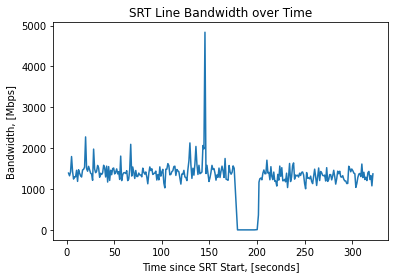

In [13]:
plt.plot(df_srt.Seconds, df_srt.mbpsBandwidth)
plt.xlabel("Time since SRT Start, [seconds]")
plt.ylabel("Bandwidth, [Mbps]")
plt.title("SRT Line Bandwidth over Time")
plt.show()

### Printing the Correlation between the Columns 

This is just an optional overview about the correlation between the columns and how for example the msRTT affects the rate of lost, dropped and re-transmitted data packets.

In [14]:
df_srt.corr()

,Seconds,SocketID,pktFlowWindow,pktCongestionWindow,pktFlightSize,msRTT,mbpsBandwidth,usPktSndPeriod,pktRecv,pktRcvLoss,...,pktRcvRetrans,pktRcvBelated,byteRecv,byteRcvLoss,byteRcvDrop,mbpsRecvRate,RCVLATENCYms,pktRcvFilterExtra,pktRcvFilterSupply,pktRcvFilterLoss
Seconds,1.000000,NaN,NaN,NaN,NaN,0.054802,-0.179923,NaN,0.998864,0.881820,...,0.883680,0.887389,0.998864,0.881820,0.881483,-0.799388,NaN,NaN,NaN,NaN
SocketID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pktFlowWindow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pktCongestionWindow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pktFlightSize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
msRTT,0.054802,NaN,NaN,NaN,NaN,1.000000,-0.492884,NaN,0.049746,0.023378,...,-0.089174,-0.087766,0.049746,0.023378,0.020228,-0.156909,NaN,NaN,NaN,NaN
mbpsBandwidth,-0.179923,NaN,NaN,NaN,NaN,-0.492884,1.000000,NaN,-0.169832,-0.217445,...,-0.128734,-0.129614,-0.169832,-0.217445,-0.215854,0.288888,NaN,NaN,NaN,NaN
usPktSndPeriod,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pktRecv,0.998864,NaN,NaN,NaN,NaN,0.049746,-0.169832,NaN,1.000000,0.858654,...,0.864162,0.868441,1.000000,0.858654,0.858306,-0.770894,NaN,NaN,NaN,NaN
pktRcvLoss,0.881820,NaN,NaN,NaN,NaN,0.023378,-0.217445,NaN,0.858654,1.000000,...,0.974558,0.972141,0.858654,1.000000,0.999982,-0.969690,NaN,NaN,NaN,NaN


# TODO

Things I wanted to do but didn't have the time to finish on time:

1. Export of the dataframes with lost, dropped, retransmitted and mbpsbandwidth dataframes into Excel file
2. Detailed explanation of all the parameters inside the dataframes
3. Fixing the documentation including special parameters, enabling encryption, etc.
4. Instruction how to build Docker Containers
5. Instruction how to deploy on physical NGINX and also on dockerized NGINX container
6. Creating a proper README.md description of the files and all the steps
7. Creating a Medium Article about the SRT Logs Analyzer

# References
1. [Haivision Official Webpage](https://www.haivision.com/)
2. [SRT Github Page](https://github.com/Haivision/srt)
3. [SRT Statistics](https://github.com/Haivision/srt/blob/master/docs/statistics.md)
4. [SRT Live Streaming](https://github.com/Haivision/srt/blob/master/docs/live-streaming.md)
5. [SRT Alliance Deployment Guide](https://www.vmix.com/download/SRT_Alliance_Deployment_Guide.pdf)
6. [SRT Unofficial Guide](https://hjortsberg.org/notes/Sending-UDP-over-Internet-using-SRT.html)
7. [SRT Log Analyzer Source Code](https://github.com/stoyanovgeorge/srt_log_analyzer)
8. [Streamlit Official Website](https://www.streamlit.io/)